In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read file
stock_path = "C:/Users/USER/Desktop/Lab/lab4.csv"
stock_df = pd.read_csv(stock_path)

In [3]:
stock_df = stock_df[["Date","Close"]]

In [4]:
scaler= MinMaxScaler(feature_range = (0,1))

In [5]:
minmax_df = scaler.fit_transform(stock_df[["Close"]].values)

In [6]:
print(minmax_df)

[[0.1465188 ]
 [0.12814316]
 [0.13684748]
 ...
 [0.39703834]
 [0.45126814]
 [0.47148938]]


In [7]:
minmax_df = pd.DataFrame(minmax_df,columns = ["Close"])

In [8]:
minmax_df["Date"] = stock_df["Date"].values

In [9]:
minmax_df[:10]

,Close,Date
0,0.146519,2010/1/20
1,0.128143,2010/1/21
2,0.136847,2010/1/22
3,0.117021,2010/1/25
4,0.098646,2010/1/26
5,0.098646,2010/1/27
6,0.115571,2010/1/28
7,0.121857,2010/1/29
8,0.119439,2010/2/1
9,0.104448,2010/2/2


In [10]:
minmax_df = minmax_df[1:]

In [11]:
train_set = minmax_df[:2200]
test_set = minmax_df[2200:]
print(train_set.shape)
print(test_set.shape)

(2200, 2)
(238, 2)


In [12]:
#hy parameter
torch.manual_seed(1)
EPOCH = 50
BATCH_SIZE = 32
TIME_STEP = 7
INPUT_SIZE = 1
LR = 0.01

In [13]:
len(minmax_df)

2438

In [14]:
# declear training features data
features = []
for i in range(TIME_STEP,len(minmax_df)):
    x = minmax_df[i-TIME_STEP:i][["Close"]].values
    features.append(x.tolist())
features = torch.FloatTensor(features)
print("size of feature: ",features.size())

# declear trainging labels data
labels = []
for i in range(TIME_STEP,len(minmax_df)):
    x = minmax_df[i:i+1]["Close"]
    labels.append(x.tolist())
labels = torch.FloatTensor(labels)
print("size of label: ",labels.size())

size of feature:  torch.Size([2431, 7, 1])
size of label:  torch.Size([2431, 1])


In [15]:
train_features = features[:2200]
train_labels = labels[:2200]
test_features = features[2200:]
test_labels = labels[2200:]

In [16]:

#Mini-Batch

torch_dataset = Data.TensorDataset(train_features,train_labels)
train_loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle=True,
)

In [17]:

#define NN architecture


class RNN(torch.nn.Module):   
    def __init__(self):
        super(RNN,self).__init__()
        # define lstm layer
        self.lstm = torch.nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,         
            num_layers=1,
            batch_first=True, 
        )
        self.lstm2 = torch.nn.LSTM(
            input_size=128,
            hidden_size=64,         
            num_layers=1,
            batch_first=True, 
        )
        # dropout layer
        self.Relu =  torch.nn.ReLU()
        self.hidden1 = torch.nn.Linear(64,32)
        self.out = torch.nn.Linear(32,1)
        
    def forward(self,x):
        lstm_out,(h_n,h_c) = self.lstm(x,None)
        lstm_out = self.Relu(lstm_out)
        lstm_out,_ = self.lstm2(lstm_out,None)
        lstm_out = self.Relu(lstm_out[:,-1,:])
        # only need last output of lstm layer
        h1_out = self.hidden1(lstm_out)
        h1_out = self.Relu(h1_out)
        out = self.out(h1_out)
        
        return out


In [18]:
model = RNN()
print(model)

RNN(
  (lstm): LSTM(1, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (Relu): ReLU()
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [19]:
# define optimizer and loss function 
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.00015)
# adject learning rate . when loss don't fall , lr = lr * factor  , min lr = 0.0001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.98,min_lr=0.0001)
# crossentroy loss 
loss_func = torch.nn.MSELoss()

In [20]:
'''
Training 
'''
LOSS = []
TEST_LOSS = []
TEST_ACC = []
TRAIN_ACC = []
for epoch in range(EPOCH):
    loss_total = 0
    for step,(inputs,targets) in enumerate(train_loader):
        inputs = inputs.view(-1,TIME_STEP,INPUT_SIZE)
        # start trainnig 
        output = model(inputs)
        # calculate loss  (cross entroy)
        loss = loss_func(output,targets)
        # clear the gradients of all optimized variables(from last training)
        optimizer.zero_grad()
        # back propagation
        loss.backward()
        optimizer.step()
        # sum of loss
        loss_total = loss_total + loss
        
        # print training info every 30 steps
        if((step+1) %30 == 0):
            # average of loss in 30 steps
            avg = loss_total / 30
            LOSS.append(avg.tolist())
            
            # calculate the accuracy of training 
            pred_train_y = torch.max(output, 1)[1].data.numpy()
            #train_accuracy = float((pred_train_y == targets.numpy()).astype(int).sum()) / float(targets.numpy().size)
            #TRAIN_ACC.append(train_accuracy)
            
            # calculate the accuracy of using testing data as inputs
            test_output = model(test_features.view(-1,TIME_STEP,INPUT_SIZE))
            pred_test_y = torch.max(test_output, 1)[1].data.numpy()
            #test_accuracy = float((pred_test_y == test_labels.numpy()).astype(int).sum()) / float(test_labels.numpy().size)
            #TEST_ACC.append(test_accuracy)
            test_loss = loss_func(test_output,test_labels)
            TEST_LOSS.append(test_loss.tolist())
            # print the epoch , steps , average loss , accuracy 
            print("Epoch: %4d|steps: %4d|Train Avg Loss: %.4f |Test Loss: %.4f|lr = %.5f"
                  %(epoch+1,step+1,avg,test_loss,optimizer.param_groups[0]['lr']))
            
            # inital variable
            loss_total = 0
    # updata learning rate
    scheduler.step(loss)
        


Epoch:    1|steps:   30|Train Avg Loss: 0.0607 |Test Loss: 0.0153|lr = 0.01000
Epoch:    1|steps:   60|Train Avg Loss: 0.0052 |Test Loss: 0.0006|lr = 0.01000
Epoch:    2|steps:   30|Train Avg Loss: 0.0011 |Test Loss: 0.0005|lr = 0.01000
Epoch:    2|steps:   60|Train Avg Loss: 0.0010 |Test Loss: 0.0006|lr = 0.01000
Epoch:    3|steps:   30|Train Avg Loss: 0.0012 |Test Loss: 0.0005|lr = 0.01000
Epoch:    3|steps:   60|Train Avg Loss: 0.0014 |Test Loss: 0.0005|lr = 0.01000
Epoch:    4|steps:   30|Train Avg Loss: 0.0011 |Test Loss: 0.0014|lr = 0.01000
Epoch:    4|steps:   60|Train Avg Loss: 0.0011 |Test Loss: 0.0005|lr = 0.01000
Epoch:    5|steps:   30|Train Avg Loss: 0.0011 |Test Loss: 0.0014|lr = 0.01000
Epoch:    5|steps:   60|Train Avg Loss: 0.0021 |Test Loss: 0.0004|lr = 0.01000
Epoch:    6|steps:   30|Train Avg Loss: 0.0017 |Test Loss: 0.0006|lr = 0.01000
Epoch:    6|steps:   60|Train Avg Loss: 0.0011 |Test Loss: 0.0009|lr = 0.01000
Epoch:    7|steps:   30|Train Avg Loss: 0.0020 |Test

In [21]:
test = model(test_features.view(-1,TIME_STEP,INPUT_SIZE))
test = test.detach().numpy()
test = scaler.inverse_transform(test)

In [22]:
len(test)

231

In [23]:
stock_df

,Date,Close
0,2010/1/20,32.144402
1,2010/1/21,30.145201
2,2010/1/22,31.092199
3,2010/1/25,28.935200
4,2010/1/26,26.936001
...,...,...
2434,2019/12/25,57.000000
2435,2019/12/26,58.299999
2436,2019/12/27,59.400002
2437,2019/12/30,65.300003


In [24]:
x = np.linspace(1,231,231)
y1 = stock_df[2208:2439]["Close"].values
y2 = test

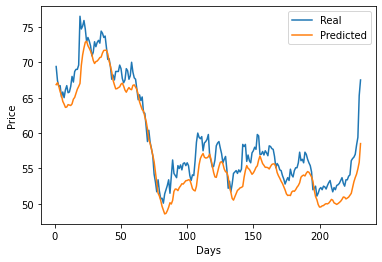

In [25]:
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(labels=['Real', 'Predicted'],  loc='best')
plt.show()

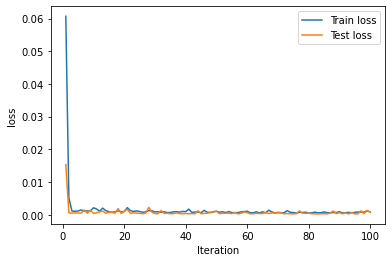

In [27]:
x = np.linspace(1,100,100)
y1 = np.array(LOSS)
y2 = np.array(TEST_LOSS)
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend(labels=['Train loss', 'Test loss'],  loc='best')
plt.show()

In [28]:
y1

array([0.06071746, 0.00515509, 0.00113316, 0.0010419 , 0.00115223,
       0.00144072, 0.00114128, 0.00114615, 0.00107807, 0.00211653,
       0.00173957, 0.00108932, 0.00201034, 0.00124701, 0.00091165,
       0.00073814, 0.00087993, 0.00117873, 0.00090055, 0.00094002,
       0.00216298, 0.00124368, 0.00098515, 0.00115662, 0.00098811,
       0.00074412, 0.0008696 , 0.00125344, 0.0011996 , 0.00086236,
       0.00090787, 0.00072631, 0.00092961, 0.00062827, 0.00067012,
       0.000877  , 0.00090941, 0.00080885, 0.00099955, 0.00092943,
       0.00171021, 0.00070414, 0.00080103, 0.0007898 , 0.00060436,
       0.00133827, 0.0007589 , 0.00066967, 0.00083553, 0.00104605,
       0.00076052, 0.00090309, 0.00063828, 0.00096539, 0.00065495,
       0.00059786, 0.00065043, 0.00085656, 0.00096789, 0.00106749,
       0.00060129, 0.0005984 , 0.0008802 , 0.0005503 , 0.00090303,
       0.00057776, 0.00137613, 0.00087283, 0.00051879, 0.00072545,
       0.00058683, 0.00060148, 0.00123434, 0.00074196, 0.00066

In [29]:
stock_df.head(10)

,Date,Close
0,2010/1/20,32.144402
1,2010/1/21,30.145201
2,2010/1/22,31.092199
3,2010/1/25,28.935200
4,2010/1/26,26.936001
5,2010/1/27,26.936001
6,2010/1/28,28.777399
7,2010/1/29,29.461300
8,2010/2/1,29.198200
9,2010/2/2,27.567301


In [30]:
t =stock_df[2208:2439]
t["predict"] = test

<ipython-input-30-df713222f770>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["predict"] = test


In [32]:
predict_price = minmax_df[:7]["Close"].values.tolist()

In [33]:
for i in range(0,2431):
    pred_input = torch.FloatTensor(np.array(predict_price[0+i:7+i]))
    pred_output = model(pred_input.view(-1,TIME_STEP,INPUT_SIZE))
    pred_output = pred_output.view(-1).detach().numpy()
    print(pred_output)
    predict_price.extend(pred_output.tolist())
    print("success")
    

[0.09744833]
success
[0.0930808]
success
[0.08729674]
success
[0.08152939]
success
[0.0759825]
success
[0.07059404]
success
[0.06530108]
success
[0.06019718]
success
[0.05545007]
success
[0.05091105]
success
[0.04662763]
success
[0.0426453]
success
[0.03896672]
success
[0.03577398]
success
[0.0331581]
success
[0.0318947]
success
[0.03127406]
success
[0.0312624]
success
[0.03125466]
success
[0.03125009]
success
[0.031248]
success
[0.03124737]
success
[0.03124722]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success


[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]


[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]


[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]


[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]


[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]
success
[0.03124719]


In [34]:
len(predict_price)

2438

In [35]:
predict_price = np.array(predict_price)
predict_price = predict_price.reshape(-1,1)
predict_price =  scaler.inverse_transform(predict_price)

In [36]:
predict_price

array([[30.145201  ],
       [31.092199  ],
       [28.9352    ],
       ...,
       [19.60327761],
       [19.60327761],
       [19.60327761]])

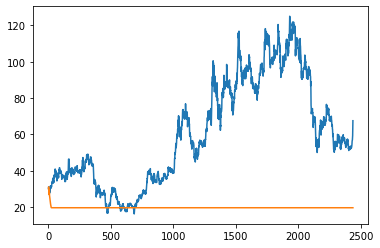

In [37]:
x = np.linspace(1,2438,2438)
y1 = predict_price
y2 = stock_df[1:]["Close"].values
plt.plot(x,y2)
plt.plot(x,y1)
plt.show()